In [1]:
%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as const
import time
import csv
import itertools

from qutip import *

np.set_printoptions(threshold=np.inf)

In [2]:
'''
Define all of our relevant basis.
'''
i=np.complex(0,1)

'''
Rotation from Lab -> Atom: R_AL: {|+>,|->} -> {|H>,|V>}

R_AL.|+>_A = |+>_L --> R_AL.(1 0)^tr = (1  i)^tr / sqrt(2)
R_AL.|->_A = |->_L --> R_AL.(0 1)^tr = (1 -i)^tr / sqrt(2)
'''
R_AL = np.sqrt(1/2) * np.matrix([[1, i],
                                 [i, 1]])

'''
Rotation from Lab -> Cavity: R_LA: {|H>,|V>} -> {|X>,|Y>}
'''
# Option 1: Measured parameters for our cavity.
alpha_CL, phi1_CL, phi2_CL = 0.459, -64.9*np.pi/180, -40.1*np.pi/180

## Option 2: Circular cavity eigenmodes.
## Note phi2=90 <--> |X>=|+>, phi2=-90 <--> |X>=|->
#alpha_CL, phi1_CL, phi2_CL = 1/np.sqrt(2), 0*np.pi/180, 90*np.pi/180

## Option 3: Linear cavity eigenmodes.
#alpha_CL, phi1_CL, phi2_CL = 1, 0*np.pi/180, 0*np.pi/180

beta_CL = np.sqrt(1-alpha_CL**2)

R_CL = np.matrix([[alpha_CL* np.exp(i*phi1_CL), -beta_CL * np.exp(-i*phi2_CL)],
                  [beta_CL * np.exp(i*phi2_CL),  alpha_CL* np.exp(-i*phi1_CL)]])
R_LC = R_CL.getH()

'''
Rotation from Atom -> Cavity: R_LA: {|+>,|->} -> {|X>,|Y>}
'''
R_AC = R_LC*R_AL
R_CA = R_AC.getH()

'''
alpha, phi for writing the atomic basis in terms of the cavity basis
'''
alpha = np.abs(R_CA[0, 0])
beta = np.sqrt(1-alpha**2)
phi1, phi2 = np.angle(R_CA[0, 0]), np.angle(R_CA[1, 0])

args_system = dict([('alpha',alpha), ('beta',beta), ('phi1',phi1), ('phi2',phi2)])

In [12]:
'''
Import coupling factors and energy level splittings from file.

The notation used is to denote the ground/excited 'F' levels with g'F'/x'F'
The magnetic 'mF' sublevels -3,-2,-1,0,1,2,3 are denoted MMM,MM,M,[nothing],P,PP,PPP.
Examples: the F'=2,mF'=3 sublevel is denoted x2PPP,
          the F=1,mF'=-1 sublevel is denoted g1M.
'''
imports = []
with open("./params/exp_params_13MHz.csv") as file:
    reader = csv.reader(file)
    for row in reader:
        imports.append(row)
        
imports = dict(map(lambda x: (str(x[0]), float(x[1])), imports))

deltaZ,deltaEx3,deltaEx1,deltaEx0,\
deltaZx3MMM,\
deltaZx3MM,deltaZx2MM,\
deltaZx3M,deltaZx2M,deltaZx1M,\
deltaZx3,deltaZx2,deltaZx1,deltaZx0,\
deltaZx3P,deltaZx2P,deltaZx1P,\
deltaZx3PP,deltaZx2PP,\
deltaZx3PPP = \
    [imports[delta]*2*np.pi for delta in 
        ["deltaZ", "deltaEx3","deltaEx1","deltaEx0",
         "deltaZx3MMM",
         "deltaZx3MM","deltaZx2MM",
         "deltaZx3M","deltaZx2M", "deltaZx1M",
         "deltaZx3","deltaZx2", "deltaZx1", "deltaZx0",
         "deltaZx3P","deltaZx2P", "deltaZx1P",
         "deltaZx3PP","deltaZx2PP",
         "deltaZx3PPP"]
     ]

'''
Shift the global energy offsets to a new level.

By default the parameter file has the energy splitting given wrt the F'=2 level. 
'''
E0shift = deltaEx1
deltaEx3,deltaEx2,deltaEx1,deltaEx0 = [deltaE - E0shift for deltaE in
                                       [deltaEx3,0,deltaEx1,deltaEx0]]

CGg1Mx3MM, CGg1Mx2MM, \
CGg1x3M, CGg1x2M, CGg1x1M, CGg1Mx3M, CGg1Mx2M, CGg1Mx1M, \
CGg1Px3, CGg1Px2, CGg1Px1, CGg1Px0, CGg1x3, CGg1x2, CGg1x1, CGg1x0, CGg1Mx3, CGg1Mx2, CGg1Mx1, CGg1Mx0, \
CGg1Px3P, CGg1Px2P, CGg1Px1P, CGg1x3P, CGg1x2P, CGg1x1P, \
CGg1Px3PP,CGg1Px2PP = [imports[CG] for CG in [
    "CGg1Mx3MM", "CGg1Mx2MM",
    "CGg1x3M", "CGg1x2M", "CGg1x1M", "CGg1Mx3M", "CGg1Mx2M", "CGg1Mx1M",
    "CGg1Px3", "CGg1Px2", "CGg1Px1", "CGg1Px0", "CGg1x3", "CGg1x2", "CGg1x1", "CGg1x0", "CGg1Mx3", "CGg1Mx2", "CGg1Mx1", "CGg1Mx0",
    "CGg1Px3P", "CGg1Px2P", "CGg1Px1P", "CGg1x3P", "CGg1x2P", "CGg1x1P", 
    "CGg1Px3PP","CGg1Px2PP"]]

CGg2MMx3MMM, \
CGg2Mx3MM, CGg2Mx2MM, CGg2MMx3MM, CGg2MMx2MM, \
CGg2x3M, CGg2x2M, CGg2x1M, CGg2Mx3M, CGg2Mx2M, CGg2Mx1M, CGg2MMx3M, CGg2MMx2M, CGg2MMx1M, \
CGg2Px3, CGg2Px2, CGg2Px1, CGg2Px0, CGg2x3,  CGg2x2, CGg2x1, CGg2x0, CGg2Mx3, CGg2Mx2, CGg2Mx1, CGg2Mx0, \
CGg2PPx3P, CGg2PPx2P, CGg2PPx1P, CGg2Px3P, CGg2Px2P,  CGg2Px1P, CGg2x3P, CGg2x2P, CGg2x1P, \
CGg2PPx3PP, CGg2PPx2PP, CGg2Px3PP, CGg2Px2PP, \
CGg2PPx3PPP = [imports[CG] for CG in [
    "CGg2MMx3MMM",
    "CGg2Mx3MM","CGg2Mx2MM", "CGg2MMx3MM", "CGg2MMx2MM",
    "CGg2x3M", "CGg2x2M", "CGg2x1M", "CGg2Mx3M", "CGg2Mx2M", "CGg2Mx1M", "CGg2MMx3M", "CGg2MMx2M", "CGg2MMx1M",
    "CGg2Px3", "CGg2Px2", "CGg2Px1", "CGg2Px0", "CGg2x3", "CGg2x2", "CGg2x1", "CGg2x0", "CGg2Mx3", "CGg2Mx2", "CGg2Mx1", "CGg2Mx0",
    "CGg2PPx3P", "CGg2PPx2P", "CGg2PPx1P", "CGg2Px3P", "CGg2Px2P", "CGg2Px1P", "CGg2x3P", "CGg2x2P", "CGg2x1P",
    "CGg2PPx3PP", "CGg2PPx2PP", "CGg2Px3PP", "CGg2Px2PP",
    "CGg2PPx3PPP"]]

# Convert all the coupling to F=2 into an overall 'dark-state' coupling.
def getCGdDecayRate(CGlist):
    return np.sqrt ( sum( [CG**2 for CG in CGlist ] ) )

CGdx0 = getCGdDecayRate([CGg2Mx0, CGg2x0, CGg2Px0])

CGdx1M = getCGdDecayRate([CGg2MMx1M, CGg2Mx1M, CGg2x1M])
CGdx1  = getCGdDecayRate([CGg2Mx1,   CGg2x1,   CGg2Px1])
CGdx1P = getCGdDecayRate([CGg2x1P,   CGg2Px1P, CGg2PPx1P])

CGdx2MM = getCGdDecayRate([CGg2MMx2MM, CGg2Mx2MM])
CGdx2M  = getCGdDecayRate([CGg2MMx2M, CGg2Mx2M, CGg2x2M])
CGdx2   = getCGdDecayRate([CGg2Mx2,   CGg2x2,   CGg2Px2])
CGdx2P  = getCGdDecayRate([CGg2x2P,   CGg2Px2P, CGg2PPx2P])
CGdx2PP = getCGdDecayRate([CGg2Px2PP, CGg2PPx2PP])

CGdx3MMM= getCGdDecayRate([CGg2MMx3MMM])
CGdx3MM = getCGdDecayRate([CGg2MMx3MM, CGg2Mx3MM])
CGdx3M  = getCGdDecayRate([CGg2MMx3M, CGg2Mx3M, CGg2x3M])
CGdx3   = getCGdDecayRate([CGg2Mx3,   CGg2x3,   CGg2Px3])
CGdx3P  = getCGdDecayRate([CGg2x3P,   CGg2Px3P, CGg2PPx3P])
CGdx3PP = getCGdDecayRate([CGg2Px3PP, CGg2PPx3PP])
CGdx3PPP= getCGdDecayRate([CGg2PPx3PPP])


'''
Physical system parameters
'''
# List the excited levels to include in the simulation.
xlvls = [
    'x0',
    #'x1'
    'x1M','x1','x1P',
    #'x2MM','x2M','x2','x2P','x2PP',
    #'x3MMM', 'x3MM','x3M','x3','x3P','x3PP', 'x3PPP'
] 

# List the coupling rates of the system.
#   kappa:  Decay of the electric field out of the cavity.
#   gamma:  Decay of the atomic amplitude.
#   deltaP: Splitting of the cavity polarisation eigenmodes.
kappa = 3.543 * 2.*np.pi /2 
gamma = 3 * 2.*np.pi
deltaP = 3.471 * 2.*np.pi

# State the detuning of the cavity and the laser w.r.t. the energy zero
# defined above (with the E0shift parameter).
deltaOffsetVStirap = 7.5 * 2.*np.pi

#deltaL = -2*deltaZ  + deltaOffsetVStirap # |F,mF>=|1,-1> <--> |F',mF'>=|1,0>
deltaL = 2*deltaZ + deltaOffsetVStirap # |F,mF>=|1,+1> <--> |F',mF'>=|1,0>
deltaC = deltaOffsetVStirap

'''
Cavity coupling.

Note g, the atom-cavity coupling rate, is given by
            d * A * coupling_factor
where,
    d: dipole moment of transition (D2 line for us).
    A: Angular dependence of the considered transition.
        e.g. A=np.sqrt(5/24) for F=1,mF=+/-1 <--> F=1,mF=0 in zero magnetic field.
'''
d = 3.584*10**(-29) # D2-line dipole moment

lambda_cav = 780.233 * 10**-9 # Resonance frequency of cavity
omega_cav = 2*np.pi * const.c / lambda_cav # Angular resonance frequency of cavity
L_cav = 339 * 10**-6 # Cavity length
R = 0.05 # Radius of curvature of cavity mirrors.
waist_cav = np.sqrt( (lambda_cav/np.pi)*np.sqrt( L_cav/2*( R - (L_cav/2) ))) # Cavity waist
V_mode = (np.pi * L_cav * waist_cav**2)/2 # Cavity mode volume.

coupling_factor = np.sqrt(omega_cav / (2*const.hbar*const.epsilon_0*V_mode))
coupling_factor /= (10**6) #Convert here so that the final coupling comes out in MHz.

'''
The variation in coupling of atoms in free-flight through the cavity mode can be
corrected for with an reduced averaged coupling.
Do so here if wanted.
'''
# coupling_factor *= 0.7

print('Atom-cavity coupling for F=1,mF=+/-1 <--> F=1,mF=1 '
      'in zero magnetic field is: g={0}MHz'.format(
        np.round(d * np.sqrt(5/24) * coupling_factor / (2*np.pi),3)))   


Atom-cavity coupling for F=1,mF=+/-1 <--> F=1,mF=1 in zero magnetic field is: g=4.775MHz


In [13]:
'''
If you want to overide the atom-cavity coupling calculated from the cavity parameters (above)
do so here.

e.g. to set g=2MHz on F=1,mF=+/-1 <--> F=1,mF=1 tranistion in zero magnetic field use
    coupling_factor = 10*2*np.pi / (d*CGg1Mx1)
'''
# coupling_factor = 10*2*np.pi / (d*CGg1Mx1)

print('Atom-cavity coupling for F=1,mF=+/-1 <--> F=1,mF=0 '
      'in zero magnetic field is: g={0}MHz'.format(
        np.round(d * np.sqrt(5/24) * coupling_factor / (2*np.pi),3))) 

Atom-cavity coupling for F=1,mF=+/-1 <--> F=1,mF=1 in zero magnetic field is: g=4.775MHz


In [14]:
'''
Here we perform the set up required before we can define and simulate the
Hamiltonian of the system.  This entails:
    1. Defining the size of our Hilbert space and how the states with it are
      labelled.
    2. Creating shorthand functions for the 'ket'/'bras' of the state vectors.
    3. Creating the operators who's expectation values we will wish to track
      through the simulations.  These are the number operators and for the
      population of each atomic state and each cavity mode in various
      polarisation bases (the cavity basis, {|H>,|V>} modes, {|+>,|->} modes
      etc.).
    4. Creating the collapse operators to account for spontaneous decay in our
      system.
'''

# Set where to truncate Fock states 0,1,2..,N-1 for cavity modes.
N = 2
cavStates = list(range(N))

# A dictionary of the atomic states.
atomStates = {
    "g1M":0, "g1":1, "g1P":2, # Corresponding to F=1,mF=-1,0,+1 respectively
    "d":3 # The 'dark-state' for all the F=2 ground levels where spont. emm. will be dumped.
}
# Add the excited-states already configured.
for k,v in zip(xlvls, range(len(atomStates), len(atomStates)+len(xlvls))):
    atomStates[k]=v
M = len(atomStates)    

'''
State definitions - pre-calculated for speed.

We create string-indexed dictionaries for the kets (|k>), bras (<b|), and
ketbras (|k><b|).
'''
def ket(atom, cavH, cavV):
    return tensor(basis(M, atomStates[atom]), basis(N, cavH), basis(N, cavV))

def bra(atom, cavH, cavV):
    return ket(atom, cavH, cavV).dag()

kets,bras = {},{}
ketbras = {}
s=[ list(atomStates) + xlvls, range(N), range(N)]
states = list(map(list, list(itertools.product(*s))))
for state in states:
    kets[str(state)] = ket(*state)
    bras[str(state)] = bra(*state)
    
for x in list(map(list, list(itertools.product(*[states,states])))):
    ketbras[str(x)] = ket(*x[0])*bra(*x[1])


'''
Shorthand definitions for coding Hamiltonians.
'''
i=np.complex(0,1)

def ePit(x,t):
    return np.exp(i*t*x)
def ePmit(x,t):
    return np.exp(-i*t*x)
def kb(x,y):
    return ketbras[str([x,y])]

'''
Create the operators that give the population of the atomic states.
'''
aDict = {}
def createStateOp(s):
    try:
        aOp = kb([s,0,0],[s,0,0]) + kb([s,1,0],[s,1,0]) + kb([s,0,1],[s,0,1])+ kb([s,1,1],[s,1,1])
        aDict[s]=aOp
    except KeyError:
        aOp =  None
    return aOp

[
    ad,
    ag1M, ag1, ag1P,
    ax0,
    ax1M, ax1, ax1P,
    ax2MM, ax2M, ax2, ax2P, ax2PP,
    ax3MMM, ax3MM, ax3M, ax3, ax3P, ax3PP, ax3PPP
] = [createStateOp(s) for s in ["d",
                                "g1M", "g1", "g1P",
                                "x0",
                                "x1M", "x1", "x1P",
                                "x2MM", "x2M", "x2", "x2P", "x2PP",
                                "x3MMM", "x3MM", "x3M", "x3", "x3P", "x3PP", "x3PPP"]]

'''
Create the photon number operators.

   anX, anY - photon number operator for cavity modes X, Y.
   
   anRotP_fast, anRotM_fast - photon number operators for different polarisation
        bases. They basis they correspond to is defined by the parameters of the 
        rotation matrix from the new basis to the cavity basis:
               R = [[alpha* np.exp(i*phi1), -beta * np.exp(-i*phi2)],
                   [beta * np.exp(i*phi2),  alpha* np.exp(-i*phi1)]].
        '_fast' denotes that these functions return the appropriate operators
        at a given time, t, with all time-independent calculations already
        performed to maximise the speed.
'''
aX = tensor(qeye(M), destroy(N), qeye(N))
aY = tensor(qeye(M), qeye(N), destroy(N))
anX = aX.dag()*aX
anY = aY.dag()*aY

# Pre-compute time independent terms to speed up calcualtions.
allAtomicStates = list(atomStates) + xlvls

an_fast_1  = sum(map(lambda s: kb([s,1,0],[s,1,0]) + kb([s,1,1],[s,1,1]), allAtomicStates))
an_fast_2  = sum(map(lambda s: kb([s,0,1],[s,0,1]) + kb([s,1,1],[s,1,1]), allAtomicStates))
an_fast_3  = sum(map(lambda s: kb([s,0,1],[s,1,0]), allAtomicStates))
an_fast_4  = sum(map(lambda s: kb([s,1,0],[s,0,1]), allAtomicStates))

def anRotP_fast(t, alpha=alpha, phi1=phi1, phi2=phi2):
    beta = np.sqrt(1-alpha**2)
    delta_phi = phi2 - phi1
    return \
        (alpha**2 * an_fast_1 + beta**2 * an_fast_2) + \
        alpha*beta * (
            np.exp(-i*deltaP*t) * np.exp(-i*delta_phi) * an_fast_3 + \
            np.exp(i*deltaP*t) * np.exp(i*delta_phi) * an_fast_4
        )

def anRotM_fast(t, alpha=alpha, phi1=phi1, phi2=phi2):
    beta = np.sqrt(1-alpha**2)
    delta_phi = phi2 - phi1
    return \
        (alpha**2 * an_fast_2 + beta**2 * an_fast_1) - \
        alpha*beta * (
            np.exp(-i*deltaP*t) * np.exp(-i*delta_phi) * an_fast_3 + \
            np.exp(i*deltaP*t) * np.exp(i*delta_phi) * an_fast_4
        )

'''
The c_op_list is the collapse operators of the system. Namely
  - the rate of photon decay from the cavity
  - spontaneous decay of the excited atomic states
'''
# Define collapse operators
c_op_list = []

# Cavity decay rate
c_op_list.append(np.sqrt(2*kappa) * aX)
c_op_list.append(np.sqrt(2*kappa) * aY)

spontEmmChannels = [
                    # |F',mF'> --> |F=1,mF=-1>
                    ('g1M','x0',CGg1Mx0),
                    ('g1M','x1M',CGg1Mx1M),('g1M','x1',CGg1Mx1),
                    ('g1M','x2MM',CGg1Mx2MM),('g1M','x2M',CGg1Mx2M),('g1M','x2',CGg1Mx2),
                    ('g1M','x3MM',CGg1Mx3MM),('g1M','x3M',CGg1Mx3M),('g1M','x3',CGg1Mx3),
    
                    # |F',mF'> --> |F=1,mF=0>
                    ('g1','x0',CGg1x0),
                    ('g1','x1M',CGg1x1M),('g1','x1',CGg1x1),('g1','x1P',CGg1x1P),
                    ('g1','x2M',CGg1x2M),('g1','x2',CGg1x2),('g1','x2P',CGg1x2P),
                    ('g1','x3M',CGg1x3M),('g1','x3',CGg1x3),('g1','x3P',CGg1x3P),
    
                    # |F',mF'> --> |F=1,mF=+1>
                    ('g1P','x0',CGg1Px0),
                    ('g1P','x1',CGg1Px1),('g1P','x1P',CGg1Px1P),
                    ('g1P','x2',CGg1Px2),('g1P','x2P',CGg1Px2P),('g1P','x2PP',CGg1Px2PP),
                    ('g1P','x3',CGg1Px3),('g1P','x3P',CGg1Px3P),('g1P','x3PP',CGg1Px3PP),
    
                    # |F',mF'> --> |F=2,mF>
                    ('d','x0',CGdx0),
                    ('d','x1M',CGdx1M),('d','x1',CGdx1),('d','x1P',CGdx1P),
                    ('d','x2MM',CGdx2MM), ('d','x2M',CGdx2M),('d','x2',CGdx2),('d','x2P',CGdx2P), ('d','x2PP',CGdx2PP),
                    ('d','x3MmM',CGdx3MMM), ('d','x3MM',CGdx3MM), ('d','x2M',CGdx3M), ('d','x2',CGdx3),('d','x2P',CGdx3P), ('d','x2PP',CGdx3PP), ('d','x2PPP',CGdx3PPP)
                    ]

spontDecayOps = []
# np.sqrt(2) in font of trans strength is because sum of strengths 
# is 1/2 for D2 but splitting ratios need to sum to 1
for x in spontEmmChannels:
    try:
       spontDecayOps.append(np.sqrt(2) * x[2] * np.sqrt(2*gamma) * 
                     tensor(
                         basis(M, atomStates[x[0]]) * basis(M, atomStates[x[1]]).dag(), qeye(N), qeye(N)))
    except KeyError:
        pass

c_op_list += spontDecayOps

sigma_spontDecayOp = sum([x.dag()*x for x in spontDecayOps])

Peak Rabi frequency of pump pulse for F=1,mF=+/-1 <--> F=1,mF=1 in zero magnetic field is: Omega=4.564MHz


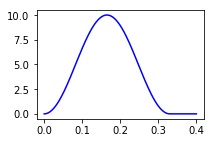

In [15]:
'''
Define the pump pulse parameters.  The pump pulse by default has a
sin**2 amplitude profile.

Parameters:
    lengthStirap - length of the pump pulse
    wStirap - pi / lengthStirap
    lengthSim - length of the simulation (as the photon can continue to decay
                out of the cavity after the pump pulse is over, we typically
                use lengthSim > lengthStirap).
    OmegaStirap - the peak Rabi frequency of the pump pulse.  Note that, again,
                  this does not include the angualr dependence of the
                  transition so the Rabi frequency on a given transition is
                        A * OmegaStirap
                where,
                    A: Angular dependence of the considered transition.
                e.g. A=np.sqrt(5/24) for F=1,mF=+/-1 <--> F=1,mF=1 in zero
                magnetic field.
'''
lengthStirap=0.33
lengthSim =0.4
OmegaStirap = 10 * 2 *np.pi

print('Peak Rabi frequency of pump pulse for F=1,mF=+/-1 <--> F=1,mF=0 '
      'in zero magnetic field is: Omega={0}MHz'.format(
        np.round(np.sqrt(5/24) * OmegaStirap/ (2*np.pi),3))) 

wStirap = np.pi / lengthStirap
t,tStep = np.linspace(0, lengthSim, 251, retstep=True)
Omega = lambda t, A=OmegaStirap, w=wStirap: np.piecewise(t, [t<lengthStirap], [A*np.sin(w*t)**2,0])

args_stirap = dict([('wStirap',wStirap), ('lengthStirap',lengthStirap), ('lengthSim',lengthSim)])

f, a1 = plt.subplots(figsize=(3, 2))
a1.plot(t, [Omega(x)/(2*np.pi) for x in t], 'b')
f.patch.set_facecolor('white')

In [17]:
'''
Create couplings for the Hamiltonian
'''

'''
Create a laser coupling.

Parameters:
    Omega - The peak rabi frequency of the pump pulse.
    g - The ground atomic atomic level.
    x - The excited atomic level.
    omegaL - The detuning of the pump laser.
    deltaM - The angular momentum change from g --> x.  This is ignored but included
             for consistancy with the cavityCoupling function.
    args_list - A dictionary of arguments for the qutip simulation.
    pulseShape - The shape of the pump pulse.
    
Returns:
    (List of cython-ready Hamiltonian terms,
     args_list with relevant parameters added)
'''
def laserCoupling(Omega,g,x,omegaL,deltaM,args_list,pulseShape='np.sin(w*t)**2'):
     omegaL_lab = 'omegaL_{0}{1}'.format(g,x)
     args_list[omegaL_lab] = omegaL
     return (
         [
         [ -(Omega/2)*(
                ( kb([g,0,0],[x,0,0]) + kb([g,0,1],[x,0,1]) + kb([g,1,0],[x,1,0]) + kb([g,1,1],[x,1,1]) ) +
                ( kb([x,0,0],[g,0,0]) + kb([x,0,1],[g,0,1]) + kb([x,1,0],[g,1,0]) + kb([x,1,1],[g,1,1]) )
        ),'{0} * np.cos({1}*t)'.format(pulseShape,omegaL_lab)],
        [ -i*(Omega/2)*(
                ( kb([g,0,0],[x,0,0]) + kb([g,0,1],[x,0,1]) + kb([g,1,0],[x,1,0]) + kb([g,1,1],[x,1,1]) ) -
                ( kb([x,0,0],[g,0,0]) + kb([x,0,1],[g,0,1]) + kb([x,1,0],[g,1,0]) + kb([x,1,1],[g,1,1]) )  
        ),'{0} * np.sin({1}*t)'.format(pulseShape,omegaL_lab)]
         ],
     args_list
     )
    

'''
Create a cavity coupling.

Parameters:
    g0 - The atom-cavity coupling rate.
    g - The ground atomic atomic level.
    x - The excited atomic level.
    omegaC - The detuning of the cavity resonance.
    deltaM - The angular momentum change from g --> x.
    args_list - A dictionary of arguments for the qutip simulation.
    
Returns:
    (List of cython-ready Hamiltonian terms,
     args_list with relevant parameters added)
'''
def cavityCoupling(g0,g,x,omegaC,deltaM,args_list):    
    omegaC_X = omegaC + deltaP/2
    omegaC_Y = omegaC - deltaP/2
    omegaC_X_lab = 'omegaC_X_{0}{1}'.format(g,x)
    omegaC_Y_lab = 'omegaC_Y_{0}{1}'.format(g,x)
    
    args_list[omegaC_X_lab] = omegaC_X
    args_list[omegaC_Y_lab] = omegaC_Y

    if deltaM==1:
        H_coupling = (
            [
                [ -g0*alpha*(
                     kb([x,0,0],[g,1,0]) + kb([x,0,1],[g,1,1]) + kb([g,1,0],[x,0,0]) + kb([g,1,1],[x,0,1]) 
                ),'np.cos({0}*t - phi1)'.format(omegaC_X_lab)],
                
                [ i*g0*alpha*(
                     kb([x,0,0],[g,1,0]) + kb([x,0,1],[g,1,1]) - kb([g,1,0],[x,0,0]) - kb([g,1,1],[x,0,1])
                ),'np.sin({0}*t - phi1)'.format(omegaC_X_lab)],
                
                [ -g0*beta*(
                    kb([x,0,0],[g,0,1]) + kb([x,1,0],[g,1,1]) + kb([g,0,1],[x,0,0]) + kb([g,1,1],[x,1,0])
                ),'np.cos({0}*t - phi2)'.format(omegaC_Y_lab)], 
        
                [ i*g0*beta*(
                    kb([x,0,0],[g,0,1]) + kb([x,1,0],[g,1,1]) - kb([g,0,1],[x,0,0]) - kb([g,1,1],[x,1,0])
                ),'np.sin({0}*t - phi2)'.format(omegaC_Y_lab)]
            ],
            args_list
        )
    elif deltaM==-1:
        H_coupling = (
            [
                [ -g0*alpha*(
                     kb([x,0,0],[g,0,1]) + kb([x,1,0],[g,1,1]) + kb([g,0,1],[x,0,0]) + kb([g,1,1],[x,1,0]) 
                ),'np.cos({0}*t + phi1)'.format(omegaC_Y_lab)],
                
                [ i*g0*alpha*(
                     kb([x,0,0],[g,0,1]) + kb([x,1,0],[g,1,1]) - kb([g,0,1],[x,0,0]) - kb([g,1,1],[x,1,0]) 
                ),'np.sin({0}*t + phi1)'.format(omegaC_Y_lab)],
                
                [ g0*beta*(
                    kb([x,0,0],[g,1,0]) + kb([x,0,1],[g,1,1]) + kb([g,1,0],[x,0,0]) + kb([g,1,1],[x,0,1])
                ),'np.cos({0}*t + phi2)'.format(omegaC_X_lab)], 
        
                [ -i*g0*beta*(
                    kb([x,0,0],[g,1,0]) + kb([x,0,1],[g,1,1]) - kb([g,1,0],[x,0,0]) - kb([g,1,1],[x,0,1])
                ),'np.sin({0}*t + phi2)'.format(omegaC_X_lab)]
            ],
            args_list
        )
    else:
        raise Exception("deltaM must be +/-1")
    
    return H_coupling
    
'''
Get the laser and cavity couplings for between
all configured levels with angular momentum changes
of +/-1.

Parameters:
    delta - The detuning of the coupling field.
'''
def getCouplings_SigmaPlus(delta):
    return [ 
    # For |F,mF>=|1,mF> <--> |F',mF'>=|3,mF+1>
    (CGg1Mx3,   'g1M', 'x3',   delta + deltaZ - deltaZx3 - deltaEx3, 1),
    (CGg1x3P,   'g1',  'x3P',  delta - deltaZx3P - deltaEx3, 1),
    (CGg1Px3PP, 'g1P', 'x3PP', delta - deltaZ - deltaZx3PP - deltaEx3, 1),
    # For |F,mF>=|1,mF> <--> |F',mF'>=|2,mF+1>
    (CGg1Mx2,   'g1M', 'x2',   delta + deltaZ - deltaZx2 - deltaEx2, 1),
    (CGg1x2P,   'g1',  'x2P',  delta - deltaZx2P - deltaEx2, 1),
    (CGg1Px2PP, 'g1P', 'x2PP', delta - deltaZ - deltaZx2PP - deltaEx2, 1),
    # For |F,mF>=|1,mF> <--> |F',mF'>=|1,mF+1>
    (CGg1Mx1,   'g1M', 'x1',   delta + deltaZ - deltaZx1 - deltaEx1, 1),
    (CGg1x1P,   'g1',  'x1P',  delta - deltaZx1P - deltaEx1, 1),
    # For |F,mF>=|1,mF> <--> |F',mF'>=|0,mF+1>
    (CGg1Mx0,   'g1M', 'x0',   delta + deltaZ - deltaZx0 - deltaEx0, 1),
    ]

def getCouplings_SigmaMinus(delta):
    return [ 
    # For |F,mF>=|1,mF> <--> |F',mF'>=|3,mF-1>
    (CGg1Mx3MM, 'g1M', 'x3MM', delta + deltaZ - deltaZx3MM - deltaEx3, -1),
    (CGg1x3M,   'g1',  'x3M',  delta - deltaZx3M - deltaEx3, -1),
    (CGg1Px3,   'g1P', 'x3',   delta - deltaZ - deltaZx3 - deltaEx3, -1),
    # For |F,mF>=|1,mF> <--> |F',mF'>=|2,mF-1>
    (CGg1Mx2MM, 'g1M', 'x2MM', delta + deltaZ - deltaZx2MM - deltaEx2, -1),
    (CGg1x2M,   'g1',  'x2M',  delta - deltaZx2M - deltaEx2, -1),
    (CGg1Px2,   'g1P', 'x2',   delta - deltaZ - deltaZx2 - deltaEx2, -1),
    # For |F,mF>=|1,mF> <--> |F',mF'>=|1,mF-1>
    (CGg1x1M,   'g1',  'x1M',  delta - deltaZx1M - deltaEx1, -1),
    (CGg1Px1,   'g1P', 'x1',   delta - deltaZ - deltaZx1 - deltaEx1, -1),
    # For |F,mF>=|1,mF> <--> |F',mF'>=|0,mF-1>
    (CGg1Px0,   'g1P', 'x0',   delta - deltaZ - deltaZx0 - deltaEx0, -1),
    ]

'''
Define the couplings used here.
'''
cavityCouplings = getCouplings_SigmaMinus(deltaC) + getCouplings_SigmaPlus(deltaC)
laserCouplings  = getCouplings_SigmaMinus(deltaL) + getCouplings_SigmaPlus(deltaL)

'''
Convert a list of couplings as returned by getCouplings...() to a list
of time-dependent Hamiltonian terms as required by qutip.mesolve(...).

Needs: couplings:  the list of couplings as returned by getCouplings...()
       rabiFreq:   the intensity of the couplings (with angular dependence factored out)
       pulseShape: the shape of the pulse (in the string format for mesolve compilation
                   into Cython).
                   If None the coupling is presumed constant and a cavityCoupling(...)
                   is set, otherwise laserCoupling(...) is used.

Returns: hams: the list of Hamiltonian terms
         args_hams: the dictionary of args needed by qutip.mesolve
'''
def couplingsToHamiltonians(couplings, rabiFreq, pulseShape=None):
    hams, args_hams = [], dict()
    for x in couplings:
        # Check if this is a coupling between configured states.
        if  x[1] in atomStates and x[2] in atomStates:
            if pulseShape != None:
                ham, args_ham = laserCoupling(rabiFreq*x[0], x[1], x[2], x[3], x[4], args_hams, pulseShape) 
            else:
                ham, args_ham = cavityCoupling(rabiFreq*x[0], x[1], x[2], x[3], x[4], args_hams) 
            hams.append(ham)
    return list(chain(*hams)), args_hams

'''
Create Hamiltonian terms for configured couplings.
'''
hams_cavity, args_hams_cavity = couplingsToHamiltonians(cavityCouplings, d*coupling_factor)
hams_laser, args_hams_laser = couplingsToHamiltonians(laserCouplings, OmegaStirap,
                                                 'np.piecewise(t, [t<lengthStirap], [np.sin(wStirap*t)**2,0])')

'''
The full list of Hamiltonian terms and arguments.
'''
H_Stirap = list(chain(*[hams_laser,hams_cavity]))
args_hams_Stirap = {**args_stirap,**args_system,
                    **args_hams_cavity,**args_hams_laser}

In [18]:
'''
When repeatedly simulating a system where only the time-dependent variables,
or initial state change, it is possible to reuse the Hamiltonian data stored
in QuTiP and there by avoid spending time needlessly preparing the Hamiltonian
and collapse terms for simulation. To turn on the the reuse features, we must
pass a qutip.Options object with the rhs_reuse flag turned on, or we can
pre-compile the Hamiltonian and pass it explicitly to the solver. 
'''

# A list of Hamiltonians to pre-compile in the form:
#    (Cythonised Hamiltonian, arguement dictionary, compiled file name)
H_list = [
    (H_Stirap, args_hams_Stirap, 'H_Stirap')
]

H_rhs_compiled=[]

for H, args, label in H_list:
    t_start = time.time()
    rhs_generate(H, c_op_list, args=args, name=label, cleanup=False)
    H_rhs_compiled.append(H)
    print('Hamiltonian \'{0}\': states pre-computed in in {1} seconds'.format(label, time.time()-t_start))

Hamiltonian 'H_Stirap': states pre-computed in in 8.305818796157837 seconds


In [22]:
'''
Perform simulation.
'''
t,tStep = np.linspace(0, lengthSim, 201, retstep=True)

psi0 = ket(*['g1P',0,0]) # Initial state of the system

opts = Options(rhs_reuse=False,rhs_filename='H_Stirap')

t_start = time.time()

output = mesolve(H_Stirap, psi0, t, c_op_list, [], options=opts, args=args_hams_Stirap, progress_bar=None)

print('Simulation with {0} timesteps completed in {1} seconds'.format(
        t.size,np.round(time.time()-t_start,3) ))

Simulation with 201 timesteps completed in 2.53 seconds


Photon: 0.083
N. spont. emm by decay operator: 0.039
Photon + / Photon - / frac_+: 0.056 / 0.027 = 0.674
Photon X / Photon Y / frac_X: 0.054 / 0.028 = 0.655
Photon H / Photon V / frac_H: 0.013 / 0.07 = 0.159
Final pops: |1,-1>,|1,1>: 0.101 0.888


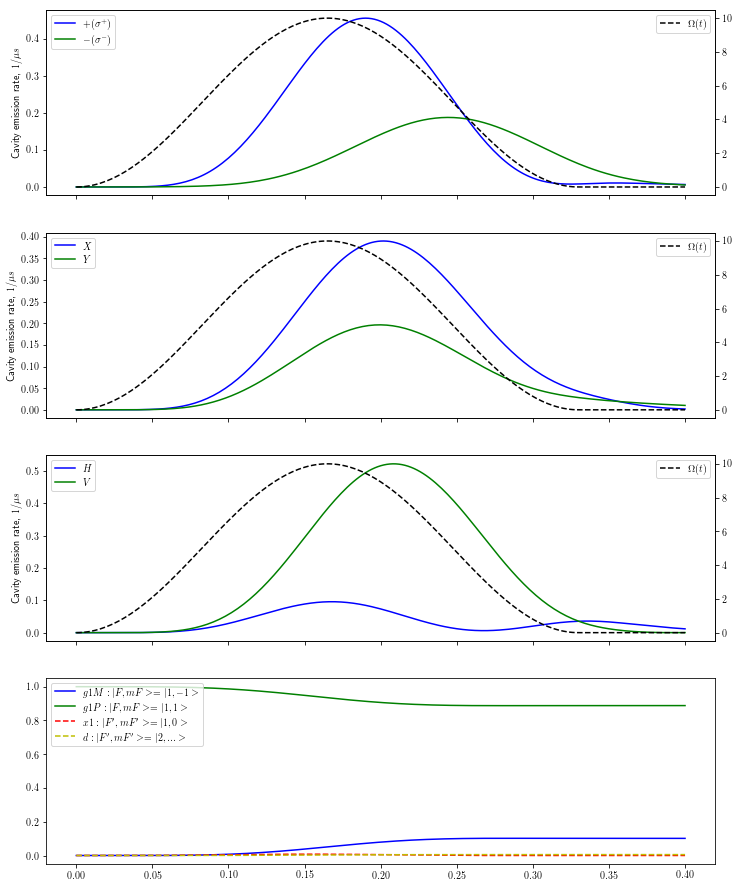

In [24]:
'''
Handle simulation results.  Here we produce plots showing the
photon emission in three polarisation bases:
    - circular {|+>,|->},
    - cavity {|X>,|Y>},
    - linear {|H>,|V>},
and the evolution of the atomic state.
'''

output_states = output.states

'''
Photon number operators for calculating the population in the
circular and linear bases.
'''
anP_t = [anRotP_fast(time, alpha=alpha, phi1=phi1, phi2=phi2) for time in t]
anM_t = [anRotM_fast(time, alpha=alpha, phi1=phi1, phi2=phi2) for time in t]
  
alpha_LC = np.clip(np.abs(R_LC[0, 0]),0,1)
phi1_LC, phi2_LC = np.angle(R_LC[0, 0]), np.angle(R_LC[1, 0])

anH_t = [anRotP_fast(time, alpha=alpha_LC, phi1=phi1_LC, phi2=phi2_LC) for time in t]
anV_t = [anRotM_fast(time, alpha=alpha_LC, phi1=phi1_LC, phi2=phi2_LC) for time in t]

'''
Calculate expectation values of photon number operators.
'''
exp_anP = np.abs(np.array([(x[0]*x[1]).tr() for x in zip(output_states, anP_t)]))
exp_anM = np.abs(np.array([(x[0]*x[1]).tr() for x in zip(output_states, anM_t)]))

exp_anH = np.abs(np.array([(x[0]*x[1]).tr() for x in zip(output_states, anH_t)]))
exp_anV = np.abs(np.array([(x[0]*x[1]).tr() for x in zip(output_states, anV_t)]))

exp_anX = np.abs(np.array([(x*anX).tr() for x in output_states]))
exp_anY = np.abs(np.array([(x*anY).tr() for x in output_states]))

exp_spontDecay = np.abs( np.array([(x*sigma_spontDecayOp).tr() for x in output_states]) )

# Total photonic population of each mode.
n_ph = np.trapz(2*kappa*(exp_anP+exp_anM), dx=tStep)

n_P = np.trapz(2*kappa*(exp_anP), dx=tStep)
n_M = np.trapz(2*kappa*(exp_anM), dx=tStep)
n_X = np.trapz(2*kappa*(exp_anX), dx=tStep)
n_Y = np.trapz(2*kappa*(exp_anY), dx=tStep)
n_H = np.trapz(2*kappa*(exp_anH), dx=tStep)
n_V = np.trapz(2*kappa*(exp_anV), dx=tStep)

# Total spontaneous emission.
n_spont = np.trapz(exp_spontDecay, dx=tStep)


# Atomic populations
exp_ag1M = np.abs(np.array([(x*ag1M).tr() for x in output_states]) )
exp_ag1P = np.abs( np.array([(x*ag1P).tr() for x in output_states]) )
exp_ax1 = np.abs( np.array([(x*ax1).tr() for x in output_states]) )

[exp_ag1, exp_ad] = [
    np.real( np.array([(x*a).tr() for x in output_states]) ) 
    for a in [ag1,ad]
]

if 'x0' in xlvls: exp_ax0 = np.real( np.array([(x*ax0).tr() for x in output_states]) )

'''
Summaries
'''
plt.rcParams['text.usetex'] = True

print('Photon emission from cavity:', np.round(n_ph,3))
print('Total spontaneous emission:', np.round(n_spont,3))
print('Photon + / Photon - / frac_+: {0} / {1} = {2}'.format(*[np.round(n,3) for n in [n_P,n_M,n_P/n_ph]]))
print('Photon X / Photon Y / frac_X: {0} / {1} = {2}'.format(*[np.round(n,3) for n in [n_X,n_Y,n_X/n_ph]]))
print('Photon H / Photon V / frac_H: {0} / {1} = {2}'.format(*[np.round(n,3) for n in [n_H,n_V,n_H/n_ph]]))

print('Final pops: |1,-1>,|1,1>:', np.round(exp_ag1M[-1],3),np.round(exp_ag1P[-1],3))

# Plot the results
f, (a1, a2, a3, a4) = plt.subplots(4, 1, sharex=True, figsize=(12, 11/.7))

a1.plot(t, 2*kappa * exp_anP, 'b', label='$+ (\sigma^{+})$')
a1.plot(t, 2*kappa * exp_anM, 'g', label='$- (\sigma^{-})$')
a1.set_ylabel('Cavity emission rate, $1/\mu s$')
a1.legend(loc=2)

a2.plot(t, 2*kappa * exp_anX, 'b', label='$X$')
a2.plot(t, 2*kappa * exp_anY, 'g', label='$Y$')
a2.set_ylabel('Cavity emission rate, $1/\mu s$')
a2.legend(loc=2)

a3.plot(t, 2*kappa * exp_anH, 'b', label='$H$')
a3.plot(t, 2*kappa * exp_anV, 'g', label='$V$')
a3.set_ylabel('Cavity emission rate, $1/\mu s$')
a3.legend(loc=2)

for a in [a1,a2,a3]:
    aB = a.twinx()
    aB.plot(t, [Omega(x)/(2*np.pi) for x in t], '--k', label='$\Omega(t)$')
    aB.legend(loc=0)

a4.plot(t, exp_ag1M,  'b', label='$g1M:|F,mF>=|1,-1>$')
a4.plot(t, exp_ag1P,  'g', label='$g1P: |F,mF>=|1,1>$')
a4.plot(t, exp_ax1,  '--r', label='$x1:  |F\',mF\'>=|1,0>$')
a4.plot(t, exp_ad,  '--y', label='$d:  |F\',mF\'>=|2,...>$')
a4.legend(loc=2)

In [25]:
'''
Jones matrices for waveplates.

theta and phi are the angle of the fast axis w.r.t. the horizontal
'''
def HWP(theta):
    return np.matrix([[np.cos(2*theta), np.sin(2*theta)],
                      [np.sin(2*theta), -1*np.cos(2*theta)]])

def QWP(phi):
    return np.matrix([[np.cos(phi)**2 + i*np.sin(phi)**2, (1-i)*np.sin(phi)*np.cos(phi)],
                      [(1-i)*np.sin(phi)*np.cos(phi),      np.sin(phi)**2 + i*np.cos(phi)**2]])

67.5
For R_CR: alpha_RC=0.54, phi1_RC=38.68, phi2_RC=44.09


Photon: 0.055
Photon |+> / Photon |->: 0.028 / 0.027
t_peak1 |+> / tpeak |->: 0.188, 0.23
0.517871378937


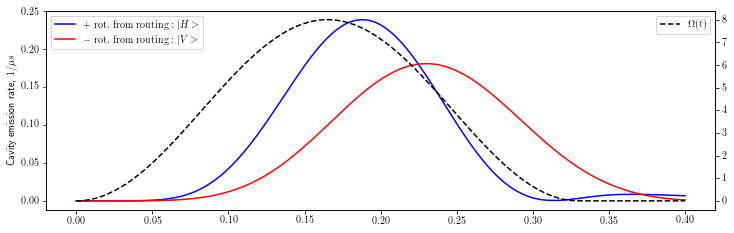

In [22]:
'''
Routing into arbitrary basis with HWP and QWP
'''
QWPfast = 41.  * np.pi/180 # fast axis of QWP

thetaHWP = 0 * np.pi/180 # angle of HWP


'''
R_CR for:
    (cavity) --> QWP --> (measure in lab <--> PBS)
'''
#phiQWP = (86  * np.pi/180) - QWPfast
phiQWP = (108.5  * np.pi/180) - QWPfast
#phiQWP = (131  * np.pi/180) - QWPfast

R_RC = R_LC * np.matrix(QWP(phiQWP)).getH()

'''
R_CR for:
    (cavity) --> QWP --> HWP --> (measure in lab <--> PBS)
'''
#R_RC = R_LC * (QWP(phiQWP) * HWP(thetaHWP)).getH()

alpha_RC = np.abs(R_RC[0, 0])
phi1_RC, phi2_RC = np.angle(R_RC[0, 0]), np.angle(R_RC[1, 0])

print('For R_CR: alpha_RC={0}, phi1_RC={1}, phi2_RC={2}'.format(*[np.round(x,2) for x in [alpha_RC, phi1_RC * 180/np.pi, phi2_RC * 180/np.pi]]))

# Calculate
anRotP_t = [anRotP_fast(t=time, alpha=alpha_RC, phi1=phi1_RC, phi2=phi2_RC) for time in t]
anRotM_t = [anRotM_fast(t=time, alpha=alpha_RC, phi1=phi1_RC, phi2=phi2_RC) for time in t]
    
exp_anRotP = np.real(np.array([(x[0]*x[1]).tr() for x in zip(output.states, anRotP_t)]))
exp_anRotM = np.real(np.array([(x[0]*x[1]).tr() for x in zip(output.states, anRotM_t)]))

# Plot the results
f, (ax) = plt.subplots(1, 1, sharex=True, figsize=(12, 11/3.))

ax.plot(t, 2*kappa * exp_anRotP, 'b', label='$\mathrm{+\ rot.\ from\ routing:\ }|H>$')
ax.plot(t, 2*kappa * exp_anRotM, 'r', label='$\mathrm{-\ rot.\ from\ routing:\ }|V>$')
ax.set_ylabel('Cavity emission rate, $1/\mu s$')

ax.legend(loc=2)

axB = ax.twinx()
axB.plot(t, [Omega(x)/(2*np.pi) for x in t], '--k', label='$\Omega(t)$')
axB.legend(loc=0)

f.patch.set_facecolor('white')

n_ph = np.trapz(2*kappa*(exp_anRotP+exp_anRotM), dx=tStep)

n_RotP = np.trapz(2*kappa*(exp_anRotP), dx=tStep)
n_RotM = np.trapz(2*kappa*(exp_anRotM), dx=tStep)

print('Photon:', np.round(n_ph,3))
print('Photon |+> / Photon |->: {0} / {1}'.format(*[np.round(n,3) for n in [n_RotP,n_RotM]]))
print('t_peak1 |+> / tpeak |->: {0}, {1}'.format(*[t[np.argmax(x)] for x in [exp_anRotP, exp_anRotM]]))
print(n_RotP/(n_RotP+n_RotM))

In [570]:
'''
Export photon shapes for outside use
'''
export_targets = [
                  (list(map(float,exp_anRotP)), 
                   "alp{0}_qwp{2}_exp_anRotP".format(*[int(np.round(alpha_CL*1000))] +
                                                      [int(np.round(x * 180/np.pi)%360) for x in [thetaHWP, phiQWP]])),
                 
                 (list(map(float,exp_anRotM)), 
                   "alp{0}_qwp{2}_exp_anRotM".format(*[int(np.round(alpha_CL*1000))] +
                                                      [int(np.round(x * 180/np.pi)%360) for x in [thetaHWP, phiQWP]]))
                  ]

if psi0 == ket(*['g1M',0,0]):
    driving_dir = 'gM_gP'
elif psi0 == ket(*['g1P',0,0]):
    driving_dir = 'gP_gM'
else:
    driving_dir = 'nonstandard_driving'
    
export_path='/data/18-08-23/Omega{0}gBar{1}deltaZ{2}/{3}/wavepackets/'.format(*[int(np.round(x/(2.*np.pi))) for x in
                                                                        [OmegaStirap,d*coupling_factor,deltaZ]] + 
                                                                        [driving_dir])
export_dir_local = '..' + export_path
export_dir_aldaq = '/Volumes/KuhnGroup/Tom/Python/STIRAP modelling_Zeeman Scheme with Birefringence' + export_path
#export_dir = '/Volumes/KuhnGroup/Tom/Python/STIRAP modelling_Zeeman Scheme with Birefringence\
#              /data/18-06-13/Omega{0}gBar{1}deltaZ{2}deltaP{3}/gM_gP'.format(*[int(np.round(x/(2.*np.pi))) for x in
#                                                                             [OmegaStirap,d*coupling_factor,deltaZ,deltaP] ])

for export_dir in [export_dir_local,export_dir_aldaq]:
    
    if not os.path.exists(os.path.dirname(export_dir)):
         try:
             os.makedirs(os.path.dirname(export_dir))
             print('created dir: ', export_dir)
         except OSError as exc: # Guard against race condition
             if exc.errno != exc.errno.EEXIST:
                 raise
         except Exception:
             pass
    
    for data, fname in export_targets:
        with open(os.path.join(export_dir, fname + '.csv'), 'w+') as file:
            wr = csv.writer(file)
            wr.writerow(data)
        print (os.path.join(export_dir, fname + '.csv'))

../data/18-08-23/Omega10gBar10deltaZ13/gP_gM/wavepackets/alp459_qwp90_exp_anRotP.csv
../data/18-08-23/Omega10gBar10deltaZ13/gP_gM/wavepackets/alp459_qwp90_exp_anRotM.csv


/Volumes/KuhnGroup/Tom/Python/STIRAP modelling_Zeeman Scheme with Birefringence/data/18-08-23/Omega10gBar10deltaZ13/gP_gM/wavepackets/alp459_qwp90_exp_anRotP.csv


/Volumes/KuhnGroup/Tom/Python/STIRAP modelling_Zeeman Scheme with Birefringence/data/18-08-23/Omega10gBar10deltaZ13/gP_gM/wavepackets/alp459_qwp90_exp_anRotM.csv


In [554]:
phis = [x*np.pi/180 for x in np.linspace(0, 360, 180)]

args = []
for phi in phis:
    # R_RC = R_LC * QWP(phi)
    R_RC = R_LC * QWP(phi).getH()
    
    alpha_RC = np.abs(R_RC[0, 0])
    phi1_RC, phi2_RC = np.angle(R_RC[0, 0]), np.angle(R_RC[1, 0])
    args.append((alpha_RC, phi1_RC, phi2_RC))

anRotP_t_list, anRotM_t_list = [], []

for alpha_CR, phi1_CR, phi2_CR in args:
    anRotP_t_list.append([anRotP_fast(t=time, alpha=alpha_CR, phi1=phi1_CR, phi2=phi2_CR) for time in t])
    anRotM_t_list.append([anRotM_fast(t=time, alpha=alpha_CR, phi1=phi1_CR, phi2=phi2_CR) for time in t])

In [571]:
'''Plot expected splitting of polarisation peaks for different routing angles'''
# phis = [(x-67.5)*np.pi/180 for x in np.linspace(0, 225, 11)]
detH_n, detV_n = [],[]

for anRotP_t, anRotM_t in zip(anRotP_t_list, anRotM_t_list):
    
    exp_anRotP = np.real(np.array([(x[0]*x[1]).tr() for x in zip(output.states, anRotP_t)]))
    exp_anRotM = np.real(np.array([(x[0]*x[1]).tr() for x in zip(output.states, anRotM_t)]))
    
    detH_n.append(np.trapz(2*kappa*(exp_anRotP), dx=tStep))
    detV_n.append(np.trapz(2*kappa*(exp_anRotM), dx=tStep))

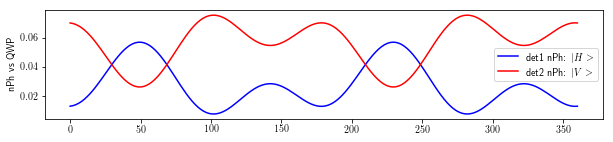

In [572]:
f, (a1) = plt.subplots(1, 1, sharex=True, figsize=(10, 2))

wpAngles = phis
pltAngles = [(180*(x))/np.pi for x in wpAngles]

a1.plot(pltAngles, detH_n, 'b', label='det1 nPh: $|H>$')
a1.plot(pltAngles, detV_n, 'r', label='det2 nPh: $|V>$')
a1.set_ylabel('nPh vs QWP')

a1.legend(loc=5)

In [573]:
export_targets = [(list(map(float,detH_n)), "alp{0}_detHn_vs_qwp".format(int(np.round(alpha_CL*1000)))),
                 
                 (list(map(float,detV_n)), "alp{0}_detVn_vs_qwp".format(int(np.round(alpha_CL*1000))))
                  ]

if psi0 == ket(*['g1M',0,0]):
    driving_dir = 'gM_gP'
elif psi0 == ket(*['g1P',0,0]):
    driving_dir = 'gP_gM'
else:
    driving_dir = 'nonstandard_driving'
    
export_path='/data/18-08-23/Omega{0}gBar{1}deltaZ{2}/{3}/routingVsQWP/'.format(*[int(np.round(x/(2.*np.pi))) for x in
                                                                        [OmegaStirap,d*coupling_factor,deltaZ]] + 
                                                                        [driving_dir])
                                                        
export_dir_local = '..' + export_path
export_dir_aldaq = '/Volumes/KuhnGroup/Tom/Python/STIRAP modelling_Zeeman Scheme with Birefringence' + export_path

for export_dir in [export_dir_local,export_dir_aldaq]:
    
    if not os.path.exists(os.path.dirname(export_dir)):
         try:
             os.makedirs(os.path.dirname(export_dir))
             print('created dir: ', export_dir)
         except OSError as exc: # Guard against race condition
             if exc.errno != errno.EEXIST:
                 raise
    
    for data, fname in export_targets:
        with open(os.path.join(export_dir, fname + '.csv'), 'w+') as file:
            wr = csv.writer(file)
            wr.writerow(data)
        print (os.path.join(export_dir, fname + '.csv'))

../data/18-08-23/Omega10gBar10deltaZ13/gP_gM/routingVsQWP/alp459_detHn_vs_qwp.csv
../data/18-08-23/Omega10gBar10deltaZ13/gP_gM/routingVsQWP/alp459_detVn_vs_qwp.csv
/Volumes/KuhnGroup/Tom/Python/STIRAP modelling_Zeeman Scheme with Birefringence/data/18-08-23/Omega10gBar10deltaZ13/gP_gM/routingVsQWP/alp459_detHn_vs_qwp.csv


/Volumes/KuhnGroup/Tom/Python/STIRAP modelling_Zeeman Scheme with Birefringence/data/18-08-23/Omega10gBar10deltaZ13/gP_gM/routingVsQWP/alp459_detVn_vs_qwp.csv
